0  Imports & базовые константы

In [26]:
import os, random, cv2, glob, torch, numpy as np
from pathlib import Path
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
os.environ['TORCHMETRICS_DISABLE_VERSION_CHECK'] = '1'


import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader

SEED   = 42
DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
root   = Path.cwd().parent          # notebooks/ → road_seg/
CITY   = root / "data" / "cityscapes"
POTH   = root / "data" / "potholes"
N_CLASSES = 4    # 0 bg, 1 road, 2 sidewalk, 3 pothole
WEIGHTS  = Path("/Users/macbook/projects/road_seg/src/best_model.pth")

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print("Device ⇒", DEVICE)

Device ⇒ mps


1  Dataset класс

In [21]:
class RoadDataset(Dataset):
    def __init__(self, img_paths, mask_paths, train=True):
        self.imgs  = img_paths
        self.masks = mask_paths
        tf_train = A.Compose([
    A.RandomScale(scale_limit=(0.7, 2.0), p=1.0),
    A.RandomRotate90(p=0.5),
    A.RandomCrop(512, 512),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.2),
    A.RandomBrightnessContrast(0.3, 0.3, p=0.3),
    ToTensorV2()
])
        tf_val = A.Compose([
    A.LongestMaxSize(max_size=512),
    A.PadIfNeeded(512, 512),
    ToTensorV2()
])
        self.tf = tf_train if train else tf_val

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img  = cv2.cvtColor(cv2.imread(str(self.imgs[idx])), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.masks[idx]), cv2.IMREAD_UNCHANGED)
        aug = self.tf(image=img, mask=mask)
        x = aug["image"].float() / 255.0      # [0,1]
        y = aug["mask"].long()
        return x, y

In [22]:
from pathlib import Path
VAL_IMG_SAMPLE = next((CITY/'images/leftImg8bit/val').rglob('*_leftImg8bit.png'))
print("sample img :", VAL_IMG_SAMPLE)

VAL_MASK_EXPECTED = Path(str(VAL_IMG_SAMPLE)
    .replace("/images/leftImg8bit/", "/masks/gtFine/")   # каталог OK
    .replace("_leftImg8bit", "_gtFine_ourIds"))
print("expected mask :", VAL_MASK_EXPECTED, VAL_MASK_EXPECTED.exists())

sample img : /Users/macbook/projects/road_seg/data/cityscapes/images/leftImg8bit/val/munster/munster_000025_000019_leftImg8bit.png
expected mask : /Users/macbook/projects/road_seg/data/cityscapes/masks/gtFine/val/munster/munster_000025_000019_gtFine_ourIds.png True


2  Сбор списков файлов

In [23]:
# --- Cityscapes -------------------------------------------------------------
def make_city_pairs(split):
    pairs = []
    for m in (CITY / "masks/gtFine" / split).rglob("*_ourIds.png"):
        img = Path(str(m)
                   .replace("/masks/gtFine/", "/images/leftImg8bit/")
                   .replace("_gtFine_ourIds", "_leftImg8bit"))
        if img.exists():
            pairs.append((img, m))
    return pairs

city_train_pairs = make_city_pairs("train")
city_val_pairs   = make_city_pairs("val")

# --- Pothole ----------------------------------------------------------------
poth_pairs = [
    (img, (POTH / "masks_png" / (img.stem + ".png")))
    for img in (POTH / "images").glob("*.jpg")
    if (POTH / "masks_png" / (img.stem + ".png")).exists()
]

# --- oversample кадры с ямами ----------------------------------------------
import cv2, random
rare_pairs = [
    p for p in poth_pairs
    if (cv2.imread(str(p[1]), cv2.IMREAD_UNCHANGED) == 3).any()
]

train_pairs = city_train_pairs + poth_pairs + rare_pairs * 4
random.shuffle(train_pairs)
val_pairs   = city_val_pairs

assert train_pairs, "train_pairs пуст!"
assert val_pairs,   "val_pairs   пуст!"

train_imgs, train_masks = zip(*train_pairs)
val_imgs,   val_masks   = zip(*val_pairs)

print(f"Train {len(train_imgs)}  |  Val {len(val_imgs)}")

Train 7466  |  Val 500


3  DataLoader’ы

In [24]:
train_ds = RoadDataset(train_imgs, train_masks, train=True)
val_ds   = RoadDataset(val_imgs,   val_masks,   train=False)

loader_tr = DataLoader(train_ds, batch_size=4, shuffle=True,  num_workers=0, pin_memory=True)
loader_va = DataLoader(val_ds,   batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

4  Модель

In [6]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    classes=N_CLASSES,
    activation=None,
).to(DEVICE)

print("params", sum(p.numel() for p in model.parameters()) / 1e6, "M")

params 26.678356 M


5  Обучение (5 эпох для пробы)

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics.classification import MulticlassJaccardIndex
from tqdm.notebook import tqdm


weights = torch.tensor([0.1, 0.4, 0.3, 0.8], device=DEVICE)  # bg, road, sidewalk, pothole
ce   = torch.nn.CrossEntropyLoss(weight=weights)
dice = DiceLoss(mode="multiclass", from_logits=True)

def loss_fn(logits, y):
    return 0.6 * ce(logits, y) + 0.4 * dice(logits, y)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)
metric_iou = MulticlassJaccardIndex(num_classes=N_CLASSES).to(DEVICE)

best_iou = 0.0

for epoch in range(7):
    model.train(); tot = 0
    for x, y in tqdm(loader_tr, desc=f"train {epoch}", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward(); optimizer.step()
        tot += loss.item()
    scheduler.step()      # скобки ✓

    # ----- валидация -----
    model.eval(); miou = 0
    with torch.no_grad():
        for x, y in loader_va:
            x, y = x.to(DEVICE), y.to(DEVICE)
            miou += metric_iou(model(x).argmax(1), y)
    miou /= len(loader_va)

    print(f"E{epoch:02d} | loss={tot/len(loader_tr):.3f} | mIoU={miou:.3f}")

     # --------- сохраняем лучший чекпоинт -----------------
    if miou > best_iou:
        best_iou = miou
        ckpt_path = root / "src" / "best_model.pth"   # src/best_model.pth
        ckpt_path.parent.mkdir(exist_ok=True)
        torch.save(model.state_dict(), ckpt_path)
        print("   ↳ new best saved:", ckpt_path)

train 0:   0%|          | 0/1867 [00:00<?, ?it/s]

E00 | loss=0.486 | mIoU=0.258
   ↳ new best saved: /Users/macbook/projects/road_seg/src/best_model.pth


train 1:   0%|          | 0/1867 [00:00<?, ?it/s]

E01 | loss=0.448 | mIoU=0.295
   ↳ new best saved: /Users/macbook/projects/road_seg/src/best_model.pth


train 2:   0%|          | 0/1867 [00:00<?, ?it/s]

E02 | loss=0.426 | mIoU=0.320
   ↳ new best saved: /Users/macbook/projects/road_seg/src/best_model.pth


In [17]:
for epoch in range(7):
    model.train(); tot = 0
    for x, y in tqdm(loader_tr, desc=f"train {epoch}", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward(); optimizer.step()
        tot += loss.item()
    scheduler.step()      # скобки ✓

    # ----- валидация -----
    model.eval(); miou = 0
    with torch.no_grad():
        for x, y in loader_va:
            x, y = x.to(DEVICE), y.to(DEVICE)
            miou += metric_iou(model(x).argmax(1), y)
    miou /= len(loader_va)

    print(f"E{epoch:02d} | loss={tot/len(loader_tr):.3f} | mIoU={miou:.3f}")

     # --------- сохраняем лучший чекпоинт -----------------
    if miou > best_iou:
        best_iou = miou
        ckpt_path = root / "src" / "best_model.pth"   # src/best_model.pth
        ckpt_path.parent.mkdir(exist_ok=True)
        torch.save(model.state_dict(), ckpt_path)
        print("   ↳ new best saved:", ckpt_path)

train 0:   0%|          | 0/1867 [00:00<?, ?it/s]

E00 | loss=0.414 | mIoU=0.299


train 1:   0%|          | 0/1867 [00:00<?, ?it/s]

E01 | loss=0.403 | mIoU=0.328
   ↳ new best saved: /Users/macbook/projects/road_seg/src/best_model.pth


train 2:   0%|          | 0/1867 [00:00<?, ?it/s]

E02 | loss=0.378 | mIoU=0.297


train 3:   0%|          | 0/1867 [00:00<?, ?it/s]

E03 | loss=0.373 | mIoU=0.309


train 4:   0%|          | 0/1867 [00:00<?, ?it/s]

E04 | loss=0.367 | mIoU=0.322


train 5:   0%|          | 0/1867 [00:00<?, ?it/s]

E05 | loss=0.349 | mIoU=0.300


train 6:   0%|          | 0/1867 [00:00<?, ?it/s]

E06 | loss=0.351 | mIoU=0.301


In [7]:
import time, torch
model.eval()
x = torch.randn(1, 3, 512, 512, device=DEVICE)

t0 = time.time()
_ = model(x)          # первый прогон – компиляция
print("1-й проход:", time.time()-t0, "сек")

t0 = time.time()
_ = model(x)          # второй – уже кэш
print("2-й проход:", time.time()-t0, "сек")

1-й проход: 0.3517630100250244 сек
2-й проход: 0.025146961212158203 сек


6  Быстрый визуальный тест

In [33]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    classes=4,
    activation=None,
)
state = torch.load(WEIGHTS, map_location="cpu")
model.load_state_dict(state, strict=False)
model.to(DEVICE, dtype=torch.float32).eval()

print("модель загружена, устройство:", DEVICE)

модель загружена, устройство: mps


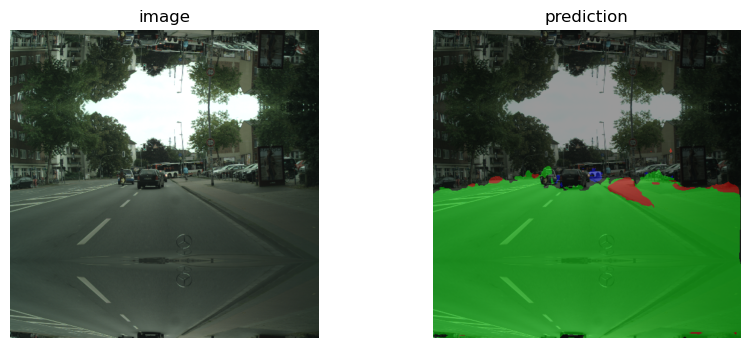

In [32]:
import matplotlib.pyplot as plt
CLRS = np.array([[0,0,0],[0,255,0],[255,0,0],[0,0,255]], np.uint8)
model.eval()
with torch.no_grad():
    x, y = next(iter(loader_va))
    pred = model(x.to(DEVICE)).argmax(1).cpu()

img_vis  = (x[0].permute(1,2,0).numpy()*255).astype(np.uint8)
mask_vis = CLRS[pred[0]]
blend = cv2.addWeighted(img_vis, 0.6, mask_vis, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_vis);  plt.title('image'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(blend);    plt.title('prediction'); plt.axis('off')
plt.show()

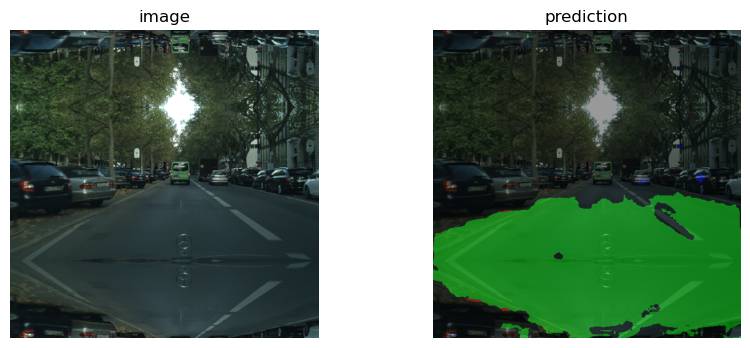

In [37]:
img_path = "/Users/macbook/projects/road_seg/data/cityscapes/images/leftImg8bit/test/berlin/berlin_000019_000019_leftImg8bit.png"

# читаем и применяем те же валидные аугментации
raw = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
aug = val_ds.tf(image=raw)["image"].unsqueeze(0).to(DEVICE) / 255.

model.eval()
with torch.no_grad():
    pred = model(aug).argmax(1).cpu()[0]

img_vis  = (aug[0].cpu().permute(1,2,0).numpy()*255).astype(np.uint8)
mask_vis = CLRS[pred]
blend    = cv2.addWeighted(img_vis, 0.6, mask_vis, 0.4, 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(img_vis);  plt.title('image'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(blend);    plt.title('prediction'); plt.axis('off')
plt.show()